In [1]:
!pip install -e C:\Users\asus_strix_scar\Anaconda3\Lib\site-packages\gym\envs\steering-optimizer\steering_optimizer\envs\github\steering-optimizer\

Obtaining file:///C:/Users/asus_strix_scar/Anaconda3/Lib/site-packages/gym/envs/steering-optimizer/steering_optimizer/envs/github/steering-optimizer
  Found existing installation: steering-optimizer 0.0.1
    Uninstalling steering-optimizer-0.0.1:
      Successfully uninstalled steering-optimizer-0.0.1
  Running setup.py develop for steering-optimizer


In [2]:
import numpy as np

In [3]:
import gym

In [4]:
for env in gym.envs.registry.env_specs.keys():
     if 'steering_optimizer' in env:
          print('Remove {} from registry".format(env)')
          del gym.envs.registry.env_specs[env]

In [5]:
from gym.envs.registration import register

register(
    id='steering_optimizer-v0',
    entry_point='steering_optimizer.envs:StrOptEnv',# kwargs={'WB': 1900, 'TW': 1200, 'KP': 150,'tr_min': 4000}
)

In [6]:
env = gym.make("steering_optimizer-v0")

In [7]:
#Fixed parameters

#Wheelbase, track width and kingpin distance

WB = 1900
TW = 1200
KP = 150

In [8]:
batch_size = 20
session_size = 20
t_max = 200
percentile = 80
hidden_size = 15
learning_rate = 0.01
completion_score = 200

In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
        
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(obs_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc0(x))
        return self.fc1(x)

    def generate_batch(self, env, batch_size, t_max):
        
        activation_1 = nn.Softmax(dim=1)
        batch_actions, batch_states, batch_rewards = [],[],[]
        # Reset only once in a batch
        s_0 = env.reset()
        
        for b in range(batch_size):
            states,actions = [],[]
            total_reward = 0
            
            s = env.reset()
            # Imitating reset, with the same state for every batch member
            #env.state = s_0
            
            #s = s_0
            
            #env.steps_beyond_done = None
            #env.error = None
            #env.max_r = None
            #env.steps_since_reset = 0
            #env.total_reward = 0
            
            #print('state shape after reset:', s.shape)
            s = s.reshape((1,4))
            
            #print('state shape after reshape:', s.shape)
            
            # step counter
            count = 0
            
            for t in range(t_max):
                count +=1
                
                # Scaling state to be within -1 and 1
                s = s/TW*2
                
                s_v = torch.FloatTensor([s]).reshape(((1,4)))
                #print('state_shape',s_v.shape)
                #s_v = torch.FloatTensor([s])
                
                #print('state: x',s_v)
                act_probs_v = activation_1(self.forward(s_v))
                act_probs = act_probs_v.data.numpy()[0]
                choice_num = len(act_probs)
                #print('num:',choice_num)
                
                ## Making only 
                #env.steps_since_reset += 1
                
                #r = -1
                
                #while r <= 0:
                #    env.steps_since_reset -= 1
                #    a = np.random.choice(choice_num, p=act_probs)
                #    
                #    new_s, r, done, info = env.step(a)
                # 
                
                a = np.random.choice(choice_num, p=act_probs)
                   
                new_s, r, done, info = env.step(a)

                states.append(s)
                actions.append(a)
                
                #print('new state',new_s)
                
                total_reward += r
                
                #print('action:',a, 'reward: ', r, 'error:', env.error, 'total reward:', total_reward)
                
                # print('total reward:', total_reward)
                # Getting the new state               
                s = new_s*TW/2
                
                # After done, no more steps
                if done:
                    #print('DONE happened')
                    break
            
            batch_actions.append(actions)
            #print('Batch member done')
            #print('Batch actions:', batch_actions[-1])
            #print('total reward on episode:', total_reward)
            
            batch_states.append(states)
            batch_rewards.append(total_reward)
        
        #print('Batch generated')
        #print('States:', batch_states)
        #print('Episode Actions:', batch_actions)
        #print('Rewards:', batch_rewards)
        
        return batch_states, batch_actions, batch_rewards

    def filter_batch(self, states_batch, actions_batch, rewards_batch, percentile):
        
        reward_threshold = np.percentile(rewards_batch, percentile)
        
        #print('reward threshold:', reward_threshold)
        
        threshold_cnt = 0
        for i in range(len(rewards_batch)):
            if rewards_batch[i] > reward_threshold:
                threshold_cnt += 1
                
        elite_states = np.array([], dtype=float)
        elite_actions = np.array([], dtype=int)
        
        elite_indices = []
        
        for i in range(len(rewards_batch)):
            if rewards_batch[i] > reward_threshold:
                elite_indices.append(i)
        
        elite_indices = np.asarray(elite_indices)
        #print('indices', elite_indices)
        
        obs_num = np.shape(env.observation_space)[0]
        #print('obs num:', obs_num)
        
        for i in range(batch_size):
            for j in range(len(states_batch[i])):
                    
                if j == 0:
                    elite_states = np.append(elite_states, states_batch[i][0][0]) 
                    elite_actions = np.append(elite_actions, actions_batch[0][0])

                else:
                    elite_states = np.append(elite_states, states_batch[i][j])
                    elite_actions = np.append(elite_actions, actions_batch[i][j])

        return elite_states, elite_actions

In [10]:
n_states = np.shape(env.observation_space)[0]
n_actions = env.action_space.n

#print(n_states, n_actions)

#neural network
net = Net(n_states, hidden_size, n_actions)

In [11]:
#loss function
objective = nn.CrossEntropyLoss()

#optimisation function
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

stats1 = np.array([])
stats2 = np.array([])
stats3 = np.array([])

for i in range(session_size):
    #generate new sessions
    batch_states,batch_actions,batch_rewards = net.generate_batch(env, batch_size, t_max)
    
    #print('batch_states', np.asarray(batch_states).reshape(-1,4))

    elite_states, elite_actions = net.filter_batch(batch_states,batch_actions,batch_rewards,percentile)
    
    #print('el_states', elite_states)
    elite_states = elite_states.reshape(-1,4)
    
    #print('el_states: reshaped', elite_states)
    #print('el_actions', elite_actions)
    
    optimizer.zero_grad()
    
    
    tensor_states = torch.FloatTensor(elite_states)
    tensor_actions = torch.LongTensor(elite_actions)

    action_scores_v = net(tensor_states)
    
    #print(action_scores_v)
    
    loss_v = objective(action_scores_v, tensor_actions)
    loss_v.backward()
    optimizer.step()

    #show results
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    print("%d: loss=%.5f, reward_mean=%.5f, reward_threshold=%.5f"% (i, loss_v.item(), mean_reward, threshold))
    
    stats1 = np.append(stats1, loss_v.item())
    stats2 = np.append(stats2, mean_reward)
    stats3 = np.append(stats3, threshold)
    
    #check if 
    if np.mean(batch_rewards)> completion_score:
        print("Environment has been successfully completed!")

Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 79.34038217863646 79.08197462721674
angdiff_c, 1: 79.34038217863646 -79.08197462721674
initial beta and beta_c -92.75696003956351 -87.24303996043649
[  0.           1.62774786   3.303749     5.03323162   6.82205859
   8.67683098  10.60501121  12.61507011  14.71666316  16.92084253
  19.24031318  21.68974284  24.28613852  27.04930441  30.00239928
  33.17261426  36.59199426  40.29842628  44.33681311  48.76043592
  53.63247377  59.02757566  65.03324033  71.75050305  79.2929874
  87.78266833  97.3396496  108.06189446 119.98904565 133.03965548
 146.88179171 160.48088254 170.28347194 173.40256967 173.87581463
 173.66912861 173.22415576 172.67121185 172.06055671 171.41536187
 170.74769781 170.0644258  169.36970542 168.66618312 167.95560462
 167.23915213 166.51764045 165.79163611 165.06153274 164.32760014]
[]
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 72.57476408630586 -160.63214402611604
angdiff_c, 1: 72.57476408630586 

initial beta and beta_c -83.37597765004587 -96.62402234995413
[   0.            1.27981887    2.58410964    3.91546592    5.2767436
    6.67109995    8.10203934    9.57346702   11.08975252   12.65580489
   14.2771623    15.96009931   17.71175591   19.54029345   21.45508413
   23.46694232   25.58840852   27.83409952   30.22114256   32.76971597
   35.50372529   38.4516518    41.64761947   45.13273716   48.95678179
   53.18029273   57.87713545   63.13754325   69.07151428   75.81214178
   83.51783562   92.37120974  102.570375    114.30542045  127.70976333
  142.77394169  159.19045192  175.68593381 -175.81084589 -175.24748655
 -175.60344241 -176.13874082 -176.73736224 -177.36561891 -178.01027562
 -178.66512286 -179.32689091 -179.99371663  179.33552106  178.66152137]
[]
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 80.18958905542635 99.32778710174986
angdiff_c, 1: 80.18958905542635 -99.32778710174983
initial beta and beta_c -90.28138254124605 -89.71861745875395
[  0.           1

angdiff_c, 0: 81.13296321656526 105.28741463746603
angdiff_c, 1: 81.13296321656526 -105.28741463746603
initial beta and beta_c -90.42759040988436 -89.57240959011565
[  0.           1.73076071   3.54318888   5.45053726   7.46879967
   9.61746506  11.92052847  14.40786495  17.1171235   20.09637798
  23.40789732  27.13359749  31.38305686  36.3054838   42.10779905
  49.08205215  57.64631561  68.40177838  82.19633449 100.13406886
 123.32213381 151.88990704 177.47645448 178.26107291 177.61112038
 176.85538697 176.06934338 175.2701084  174.46360693 173.65236665
 172.83759511 172.01989816 171.19957446 170.37675162 169.55145498
 168.72364495 167.89323827 167.06012078 166.22415519 165.38518603
 164.54304274 163.69754162 162.848487   161.9956719  161.13887828
 160.27787703 159.4124277  158.54227807 157.66716353 156.78680638]
[]
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 79.64371882214648 82.30083975239265
angdiff_c, 1: 79.64371882214648 -82.30083975239265
initial beta and beta_c -

initial beta and beta_c -101.1333831138035 -78.86661688619648
[  0.           1.88159097   3.82353133   5.83182147   7.91312871
  10.07488273  12.32538601  14.67394143  17.13099991  19.70833078
  22.41921814  25.27868597  28.30375452  31.51372938  34.93052221
  38.57899821  42.48733835  46.687393    51.21498565  56.1100969
  61.41681733  67.18289646  73.45863106  80.29472629  87.7386306
  95.82869235 104.58528357 113.99756358 124.00277844 134.4473899
 144.98534589 154.7273465  161.52864336 164.22966285 164.86419762
 164.78247049 164.41545027 163.91180543 163.33309086 162.70878848
 162.05462181 161.37967656 160.68953235 159.98778001 159.27681564
 158.55828275 157.83333172 157.10277855 156.36720578 155.62702855]
[]
6: loss=0.04137, reward_mean=-37.74900, reward_threshold=-10.00000
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 73.20115259432662 91.56968937978324
angdiff_c, 1: 73.20115259432662 -91.56968937978324
initial beta and beta_c -87.0278954808623 -92.97210451913772
[  

11: loss=0.04147, reward_mean=-27.76600, reward_threshold=-10.00000
12: loss=0.03531, reward_mean=-36.55900, reward_threshold=-10.04000
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 79.69108913715559 89.96917627181085
angdiff_c, 1: 79.69108913715559 -89.96917627181085
initial beta and beta_c -91.42034621720634 -88.57965378279366
[  0.           1.64451536   3.34507629   5.10856213   6.94284492
   8.85698055  10.86144372  12.96841871  15.1921614   17.54945271
  20.06017044  22.74801433  25.64143119  28.77480086  32.18996273
  35.93818438  40.08269719  44.70194066  49.89364791  55.77982311
  62.51240475  70.27876416  79.30475369  89.85015067 102.18642191
 116.54046811 132.98513165 151.25697049 170.09084533 177.25812609
 176.98690783 176.3561947  175.65548903 174.92924707 174.19059559
 173.44472369 172.69404747 171.93980722 171.18267439 170.42301735
 169.66103028 168.89680101 168.1303489  167.36164713 166.59063637
 165.81723337 165.04133659 164.26282984 163.48158474 162.69746

 158.09148501 157.2862556  156.47701747 155.66369524 154.84618653]
[]
15: loss=0.03800, reward_mean=-34.22800, reward_threshold=-10.00800
16: loss=0.07495, reward_mean=-20.38000, reward_threshold=-10.00000
Not monotonic! -> Bad configuration! loop: 0
angdiff_c, 0: 79.36217263649657 99.36067721257378
angdiff_c, 1: 79.36217263649657 -99.36067721257373
initial beta and beta_c -88.78385499041809 -91.21614500958192
[  0.           1.59901874   3.25873023   4.98778526   6.79633811
   8.69639618  10.70226929  12.83115245  15.1038899   17.54598769
  20.18897123  23.07222739  26.24553481  29.7725829   33.73592363
  38.24401069  43.44127137  49.52250486  56.75312836  65.49621766
  76.24372212  89.63654997 106.42264507 127.2270252  151.89933687
 175.99694872 179.64620392 179.26076037 178.6109677  177.89314266
 177.14762679 176.38783799 175.61944897 174.84522193 174.06662415
 173.28447449 172.49923712 171.71116827 170.92039496 170.12695999
 169.33084865 168.53200536 167.73034426 166.92575613 166.1

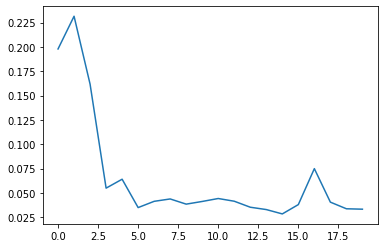

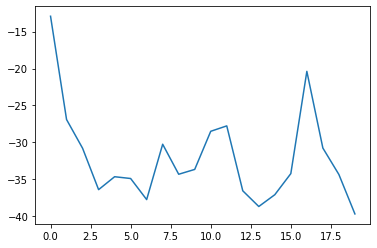

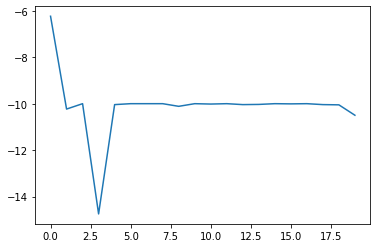

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.plot(stats1)
plt.figure()
plt.plot(stats2)
plt.figure()
plt.plot(stats3)